# Feature-preserving smoothing

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

First, we load the base image _eagle.jpg_.

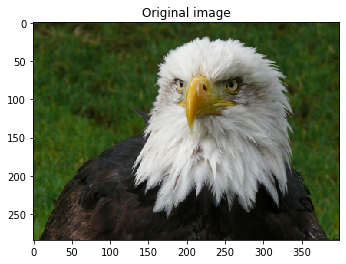

In [27]:
clean = cv2.imread('data/3-eagle.jpg')
clean = cv2.cvtColor(clean, cv2.COLOR_BGR2RGB)
plt.imshow(clean)
plt.title("Original image")
plt.show()

## Gaussian blur
We then apply the Gaussian Blur function from __cv2__, using a kernel of size $9 \times 9$ with a standard deviation of 0.

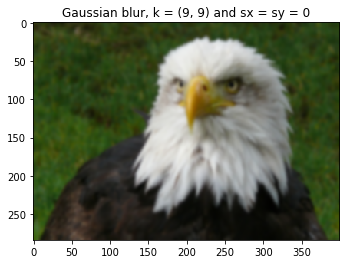

In [28]:
gaussian = cv2.GaussianBlur(clean,(9,9),0)
plt.imshow(gaussian)
plt.title("Gaussian blur, k = (9, 9) and sx = sy = 0")
plt.show()

We calculate the difference between the original image _clean_ and the blurred image _gaussian_. We verify that the difference between them are the contours, which are smoothed by the gaussian blur.

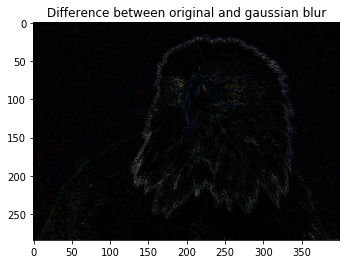

In [29]:
difference = cv2.absdiff(gaussian, clean)
plt.imshow(difference)
plt.title("Difference between original and gaussian blur")
plt.show()

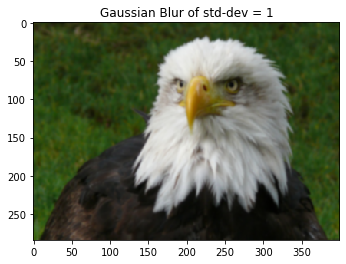

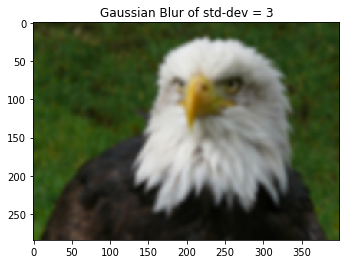

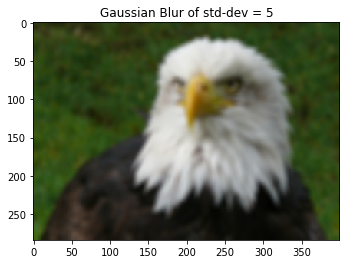

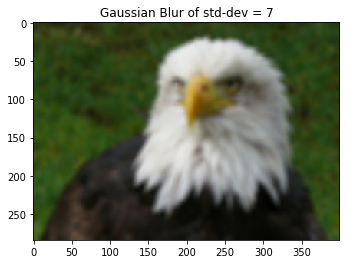

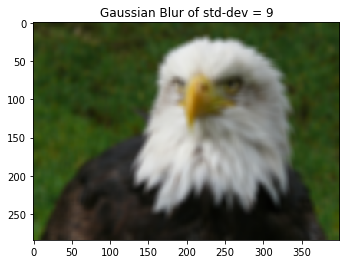

In [30]:
for std in range(1, 10, 2):
    gaussian = cv2.GaussianBlur(clean,(9,9),std)
    plt.figure()
    plt.imshow(gaussian)
    plt.title("Gaussian Blur of std-dev = " + str(std))
    plt.show()

We verify that the higher is the value of the standard deviation, the smoother is the resulting image.

## Bilateral filter
In the cell bellow we apply the bilateral filter, which has a kernel that analyses both color and space, and preserves the contours of the image, as we can see bellow.

This function takes as arguments the following values:
* __d__, which is the diameter of the pixel neighborhood;
* __sigmaColor__, that indicates the standard deviation used when treating the colors, and
* __sigmaSpace__, that indicates the standard deviation of the space.

Text(0.5, 1.0, 'Bilateral, d=30, sc = 50, ss = 5')

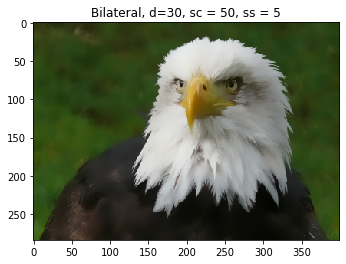

In [31]:
bilateral = cv2.bilateralFilter(clean, d=5*6, sigmaColor=50, sigmaSpace=5)
plt.imshow(bilateral)
plt.title("Bilateral, d=30, sc = 50, ss = 5")

The function bellow calculates the result of the bilateral function and the difference between it and the original image.

In [32]:
def calculateBilateralAndPlot(d, sc, ss, img):
    bilateral = cv2.bilateralFilter(img, d, sc, ss)
    difference = cv2.subtract(bilateral, img)
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(bilateral)
    ax[0].set_title("Bilateral")
    ax[1].imshow(difference)
    ax[1].set_title("Difference")
    plt.suptitle("(d, sigmaColor, sigmaSpace) = (" + str(d) + ", " 
                 + str(sc) + ", " + str(ss) + ")")

Here, we calculate two bilateral filters:
* d equals to 30, sigmas of colors and space equals to 100.
* d equals to 30, sigmas of color and space equals to 2.

We can verify that a low standard deviation has, as expected, a low impact on the smoothing of the textures.

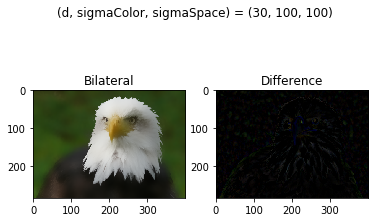

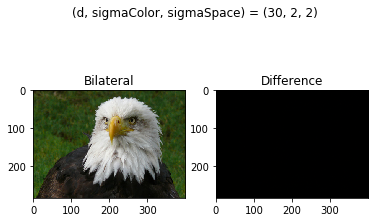

In [33]:
calculateBilateralAndPlot(30, 100, 100, clean)
calculateBilateralAndPlot(30, 2, 2, clean)

The function bellow applies the bilateral filter to the image multiple times.

In [34]:
def iterateBilateral(img, n_it):
    blured = cv2.bilateralFilter(img, 30, 120, 50)
    for i in range(n_it - 1):
        blured = cv2.bilateralFilter(blured, 30, 120, 50)
    return blured

We see that a higher number of iterations has a similar effect of the one of using a big standard deviation.

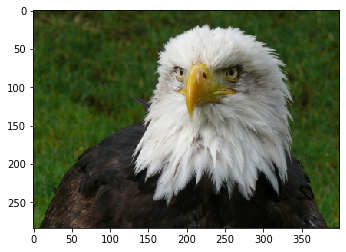

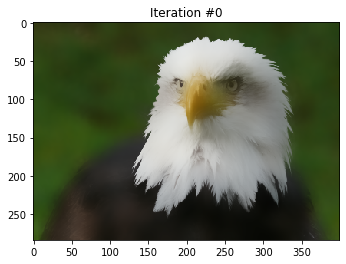

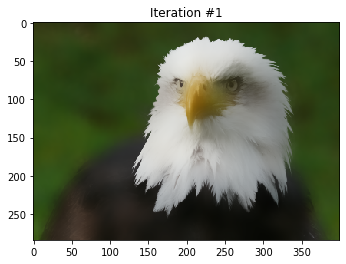

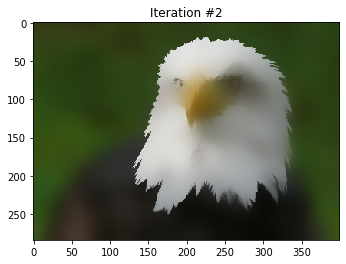

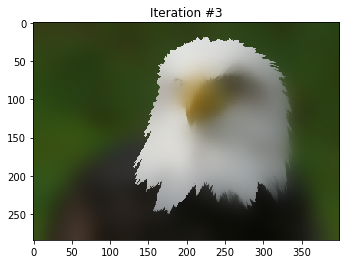

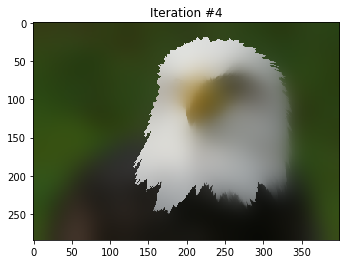

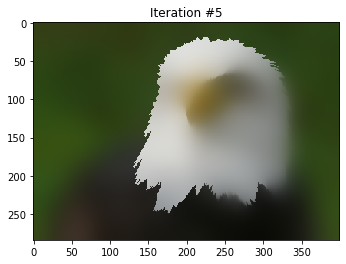

In [35]:
plt.imshow(clean)
for i in range(6):
    plt.figure()
    blured = iterateBilateral(clean, i)
    plt.imshow(blured)
    plt.title("Iteration #" + str(i))

## NL-means filter
In the cell bellow we test the NL-means filter. This filter is a generalization, and can be specialized into a bilateral filter.

The Non Local refers to the fact that this method does not analyse a single neighborhood to define the mean, but the whole image. Each pixel has then a specific weight on the mesure.

The parameters for this method are:
* __h__, which defines the strenght of the filter when treating the luminance component,
* __hColor__ has the same role of __h__, but it deals with the color of the image,
* __templateWindowSize__ is an odd number that indicates the size of the patch, and
* __searchWindowSize__ which is the size of the window to compute the average weight of a pixel.

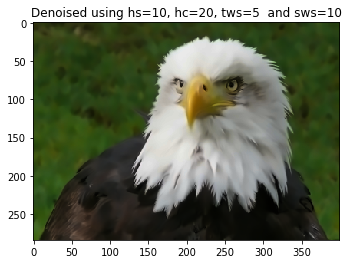

In [36]:
denoised = cv2.fastNlMeansDenoisingColored(clean, h=10, hColor=20,
                                          templateWindowSize=5,
                                          searchWindowSize=10)
plt.imshow(denoised)
plt.title("Denoised using hs={}, hc={}, tws={}  and sws={}".format(10, 20, 5, 10))
plt.show()

In the cell bellow we compare the bilateral filter (d=30, sc=ss=100) and the denoising function (the result above). We verify that, for these conditions, both results are similar.

Text(0.5, 1.0, 'Denoised difference')

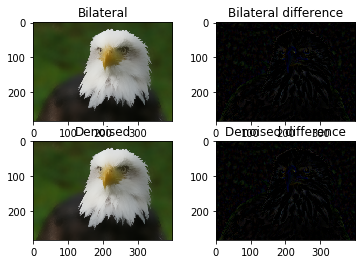

In [37]:
bilateral = cv2.bilateralFilter(clean, d=5*6, sigmaColor=100, sigmaSpace=100)
diff_bila = cv2.subtract(bilateral, clean)
diff_deno = cv2.subtract(denoised, clean)
fig, ax = plt.subplots(2, 2)
ax[0,0].imshow(bilateral)
ax[0,0].set_title("Bilateral")
ax[0,1].imshow(diff_bila)
ax[0,1].set_title("Bilateral difference") 
ax[1,0].imshow(bilateral)
ax[1,0].set_title("Denoised")
ax[1,1].imshow(diff_bila)
ax[1,1].set_title("Denoised difference") 

## Guided filtering
Here we are going to analyse how we can smooth an image using another one as guide.

First, we extract the edges of the image using the Sobel operator. It takes as parameters the order of the derivatives of dx and dy, and the size of the kernel it is going to use. As we did not specify the size, the kernel used is $3 \times 3$.

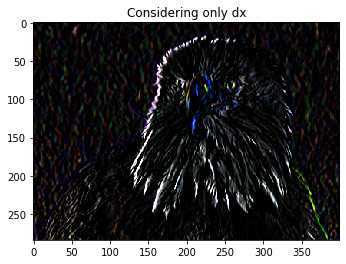

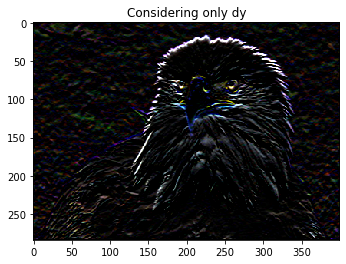

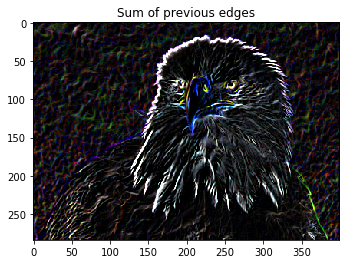

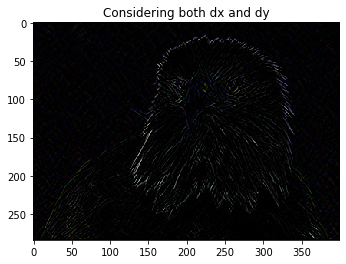

In [38]:
plt.figure()
sobelx = cv2.Sobel(clean, cv2.CV_8U, 1, 0)
plt.imshow(sobelx)
plt.title("Considering only dx")
plt.figure()
sobely = cv2.Sobel(clean, cv2.CV_8U, 0, 1)
plt.imshow(sobely)
plt.title("Considering only dy")
plt.figure()
sobelxy = cv2.add(sobelx, sobely)
plt.imshow(sobelxy)
plt.title("Sum of previous edges")
plt.figure()
sobel = cv2.Sobel(clean, cv2.CV_8U, 1, 1)
plt.imshow(sobel)
plt.title("Considering both dx and dy")
plt.show()

The second step is to apply the joint bilateral filter. This method takes as parameters the following:
* __joint__, which is the guiding image,
* __src__, which is the image we are trying to smooth,
* __d__, size of neighborhood (as in the bilateral filter),
* __sigmaColor__ and __sigmaSpace__, that have the same role as seen before.

In [39]:
## ATTENTION: to execute the line bellow, you must have installed
##            opencv-contrib-python==3.3.0.9
joint = cv2.ximgproc.jointBilateralFilter(sobel, clean, 10, 120, 50)
plt.figure()
plt.imshow(clean)
plt.figure()
plt.imshow(joint)

AttributeError: module 'cv2.cv2' has no attribute 'ximgproc'

In [62]:
def abstraction(img):
    filtered = cv2.bilateralFilter(img, 20, 100, 100)
    sobelx = cv2.Sobel(img, cv2.CV_8U, 1, 0)
    sobely = cv2.Sobel(img, cv2.CV_8U, 0, 1)
    edges = cv2.add(sobelx, sobely)
    gray = cv2.cvtColor(edges, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    mask_inv = cv2.bitwise_not(mask)
    return cv2.bitwise_and(filtered, filtered, mask = mask_inv)

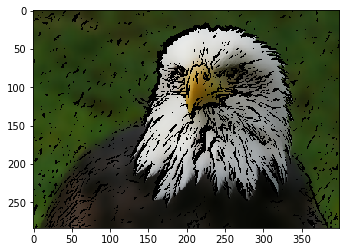

In [63]:
res = abstraction(clean)
plt.figure()
plt.imshow(res)

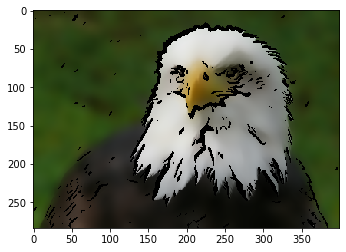

In [64]:
res = abstraction(denoised)
plt.imshow(res)

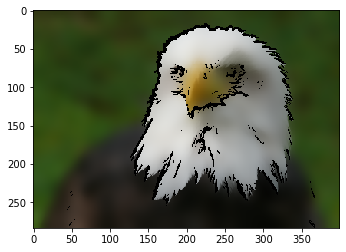

In [65]:
bilateral = cv2.bilateralFilter(clean, 20, 100, 100)
res = abstraction(bilateral)
plt.imshow(res)